In [1]:
import keras
from keras.layers import Flatten, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from scipy import spatial
from matplotlib.patches import Rectangle
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import search
import utils
import models
%matplotlib inline

Using TensorFlow backend.
/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,
/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [2]:
#full image view and full image as array
img = image.load_img("ny_resized.jpg")
full_img = image.img_to_array(img)

Definitions

In [11]:
model_width = 224
half_model_width = int(224 * .5)
est_location = 200
half_est_location = int(est_location * .5)

In [12]:
#actual locations, random locations, pix locations are visual points of interest
#pix_x, pix_y = 639, 750
pix_x, pix_y = 465, 635
#pix_x, pix_y = 1211, 1038
rand_pix_x = np.random.randint(pix_x - half_est_location, pix_x + half_est_location)
rand_pix_y = np.random.randint(pix_y - half_est_location, pix_y + half_est_location)
x_start_num, x_finish_num, y_start_num, y_finish_num= utils.start_lines(pix_x, pix_y)
rand_x_start, rand_x_fin, rand_y_start, rand_y_fin = utils.start_lines(rand_pix_x, rand_pix_y)

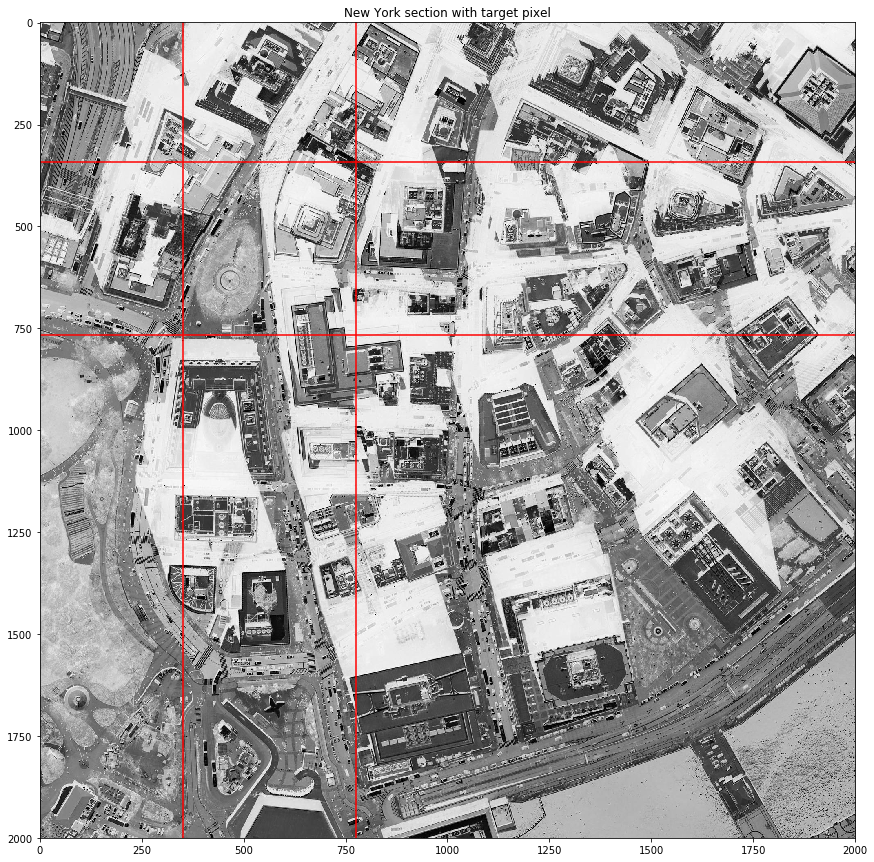

In [13]:
#return subarray (tee_ny) from full image, arbitrarily chosen
tee_ny = full_img[8250: 10250, 5000:  7000, :]
tee_ny_img = image.array_to_img(tee_ny)
plt.figure(figsize = (15,15))
plt.axvline(x= rand_x_start, color= 'red')
plt.axvline(x= rand_x_fin, color= 'red')
plt.axhline(y= rand_y_start, color= 'red')
plt.axhline(y= rand_y_fin, color= 'red')
plt.title('New York section with target pixel')
plt.imshow(tee_ny);

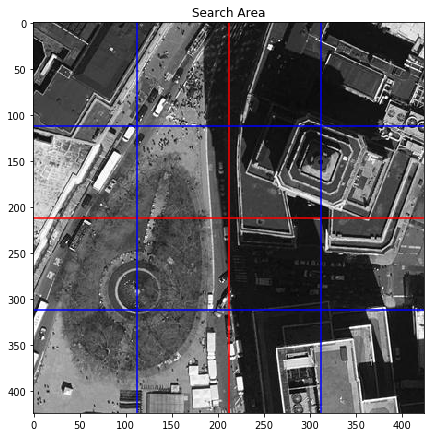

In [14]:
search_img = tee_ny[rand_y_start : rand_y_fin, rand_x_start: rand_x_fin, :]
search_img = image.array_to_img(search_img)
plt.figure(figsize = (7,10))
plt.title('Search Area')
plt.axvline(x = 212, color = 'red')
plt.axhline(y = 212, color = 'red')
plt.axvline(x = 212 - 100, color = 'blue')
plt.axhline(y = 212 + 100, color = 'blue')
plt.axvline(x = 212 + 100, color = 'blue')
plt.axhline(y = 212 - 100, color = 'blue')
#plt.axis('off')
plt.imshow(search_img);

(224, 224, 3)


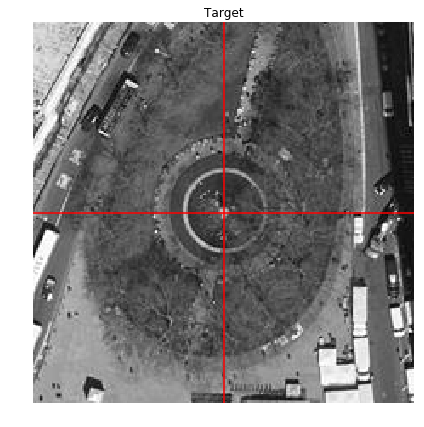

In [15]:
#Target Image and target to predict
x_img_array = utils.get_img_slice(tee_ny, x_start_num, y_start_num, model_width)
print(x_img_array.shape)
x_img = image.array_to_img(x_img_array)
goal_pred = models.get_pred(x_img)
plt.figure(figsize = (7,7))
plt.title('Target')
plt.axvline(x= model_width * .5, color= 'red')
plt.axhline(y= model_width * .5, color= 'red')
plt.axis('off')
plt.imshow(x_img);

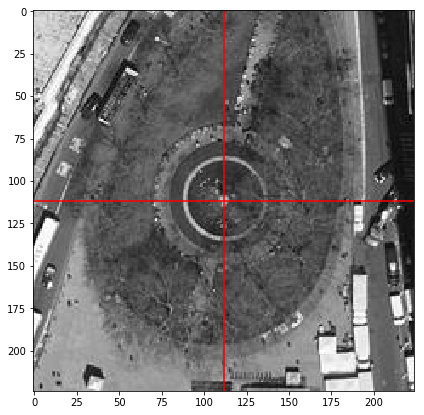

In [16]:
#x, y = narrowing_search()
x, y = search.deviation_assisted_search(tee_ny, rand_x_start, rand_x_fin, rand_y_start, rand_y_fin, goal_pred, 25)
#x, y = deviation_assisted_search()
z_img = utils.get_img_slice(tee_ny, x, y, model_width)
z_img = image.array_to_img(z_img)
plt.figure(figsize = (7,7))
plt.axvline(x = model_width * .5, color = 'red')
plt.axhline(y = model_width * .5, color = 'red')
plt.imshow(z_img);

In [17]:
x + half_model_width + half_est_location, y + half_model_width + half_est_location

(465, 635)

In [18]:
pix_x, pix_y

(465, 635)